In [1]:
# !pip install scikit-multilearn

In [2]:
# !pip install emoji

In [3]:
import warnings
warnings.filterwarnings('ignore')

from helper_functions import *
from MultiLabel import MultiLabel as mll
from TweetProcessor import TweetProcessor as tp

tweet_processor = tp.TweetProcessor()

In [4]:
def addValuesToResults(result):   
   accuracy_res.append(result['accuracy'])
   precision_res.append(result['precision'])
   recall_res.append(result['recall'])
   f1_res.append(result['f1_score'])
   hamming_res.append(result['hamming_loss'])

Import data

In [5]:
emo_train_df = pd.read_csv('data/2018-E-c-En-train.txt', sep='\t')
emo_test_df = pd.read_csv('data/2018-E-c-En-test-gold.txt', sep='\t')
print(emo_train_df.shape)
emo_train_df.head()

(6838, 13)


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


### Data exploration
Class distribution

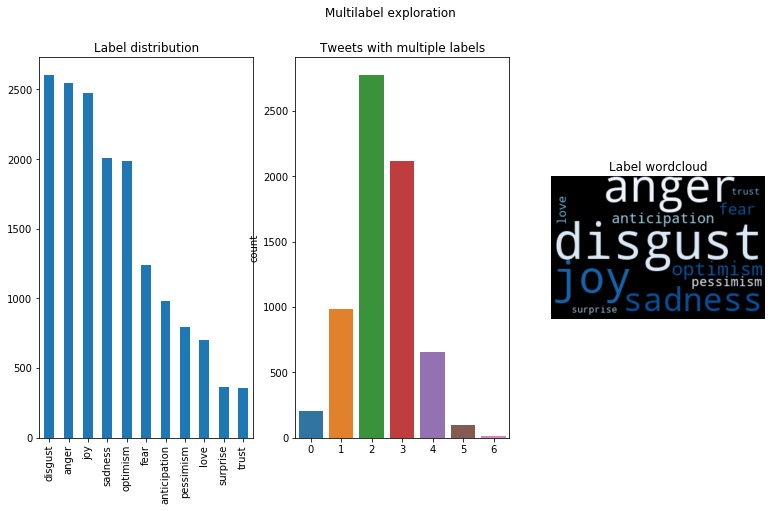

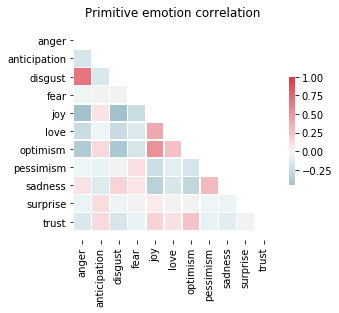

In [6]:
feelings = emo_train_df.columns[2:]#['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
multilabel_visualization(emo_train_df[feelings].values, feelings)

### Preprocessing:
* Tokenization
* Stopword removal
* Special character handling
* Emoji parsing
* Data cleaning


In [7]:
# preprocessing test and training sets
combined_df = pd.concat([emo_train_df, emo_test_df])
combined_df['tokenized_features'] = combined_df['Tweet'].apply(tweet_processor.tweet_pipeline)
X = combined_df['tokenized_features'].apply(lambda x: ' '.join(x)).values

# TF-IDF text features
vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = vectorizer.transform(X)

# TF-IDF emoji features
vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = vectorizer.transform(X)

# Combine features
X_combined = np.hstack((X_tfidf.toarray(), X_emoji.toarray()))

emo_train_df['feature_vector'] = X_combined[:emo_train_df.shape[0]].tolist()
emo_test_df['feature_vector'] = X_combined[-emo_test_df.shape[0]:].tolist()
emo_train_df['feature_vector'].shape, emo_test_df['feature_vector'].shape

# splitting datasets to train and test sets
x_train = np.vstack(emo_train_df['feature_vector'].values)
x_test = np.vstack(emo_test_df['feature_vector'].values)
y_train = emo_train_df[feelings].values
y_test = emo_test_df[feelings].values
x_train.shape, y_train.shape, x_test.shape

((6838, 4824), (6838, 11), (3259, 4824))

Multilabel demonstration

In [8]:
Multilabel = mll.Multilabel(x_train, y_train, x_test, y_test, feelings.values)

accuracy_res = []
precision_res = []
recall_res = []
f1_res = []
hamming_res = []
labels = []

In [9]:
results = Multilabel.oneVsRest()
addValuesToResults(results)
labels.append("oneVsRest")


Starting One Vs Rest Classifier of sklearn.multiclass...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   14.5s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   14.7s finished


Finished training in :  0:00:20.167347
(4, {0: array(['fear', 'pessimism', 'sadness'], dtype=object), 1: array(['joy', 'love', 'optimism'], dtype=object), 2: array(['anger', 'disgust'], dtype=object), 3: array(['anticipation', 'surprise', 'trust'], dtype=object)})


In [10]:
results = Multilabel.MLkNN()
addValuesToResults(results)
labels.append("MLkNN")


Starting MLkNN Classifier of skmultilearn.adapt...

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 12.2min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.6min finished


(2, {0: array(['anticipation', 'fear', 'joy', 'love', 'optimism', 'pessimism',
       'surprise', 'trust'], dtype=object), 1: array(['anger', 'disgust', 'sadness'], dtype=object)})


In [11]:
results = Multilabel.LabelPowerset()
addValuesToResults(results)
labels.append("LabelPowerset")


Starting LabelPowerset Classifier of skmultilearn.problem_transform...

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    7.7s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.9s finished


Finished training in :  0:00:09.204576
None


In [12]:
results = Multilabel.ClassifierChain()
addValuesToResults(results)
labels.append("ClfChain")


Starting ClassifierChain Classifier of skmultilearn.problem_transform...

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   32.1s remaining:   32.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.0s finished


Finished training in :  0:00:46.876999
(5, {0: array(['anger', 'disgust', 'sadness'], dtype=object), 1: array(['love', 'trust'], dtype=object), 2: array(['fear', 'pessimism'], dtype=object), 3: array(['anticipation', 'surprise'], dtype=object), 4: array(['joy', 'optimism'], dtype=object)})


In [13]:
results = Multilabel.BinaryRelevance()
addValuesToResults(results)
labels.append("BinaryRel")


Starting BinaryRelevance Classifier of skmultilearn.problem_transform...

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   18.2s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.3s finished


Finished training in :  0:00:27.001555
(3, {0: array(['anticipation', 'fear', 'pessimism', 'sadness', 'surprise',
       'trust'], dtype=object), 1: array(['joy', 'love', 'optimism'], dtype=object), 2: array(['anger', 'disgust'], dtype=object)})


In [14]:
results = Multilabel.MajorityVotingClassifier()
addValuesToResults(results)
labels.append("MajVotClf")


Starting MajorityVotingClassifier Classifier of skmultilearn.ensemble...

Finished training in :  0:00:00.000106
None


Visualization

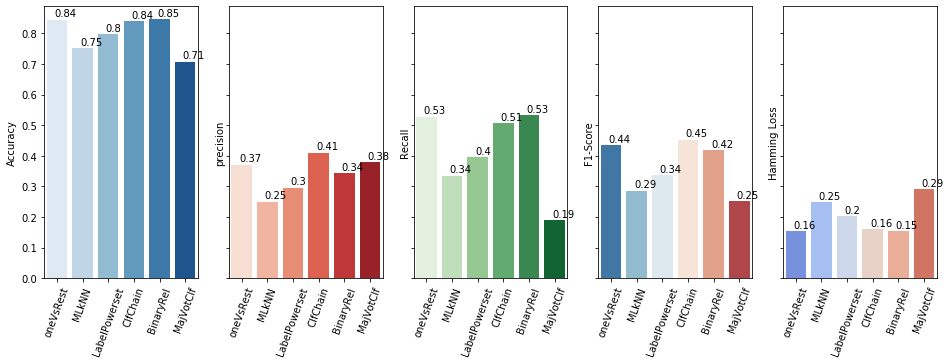

In [15]:
Multilabel.plotScores(accuracy_res, precision_res, recall_res, f1_res, hamming_res, labels)